Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

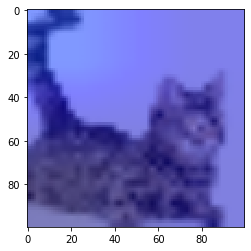

In [9]:
from skimage import io
#from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import cv2
from keras import backend as K
from keras.preprocessing import image
from keras.models import load_model
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
%matplotlib inline
cifar10classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

def imshow(img):
    plt.imshow(img)
    
def decode_prediction(idx):
    return idx

def create_heatmap(model, last_conv_layer_id, last_conv_layer_channels, input_size, img_url):  
  img = io.imread(img_url)
  img = cv2.resize(img, dsize=(input_size, input_size), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  imshow(cv2.resize(img, (100,100)))
  print("predicted: ", decode_prediction(class_idx))
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(last_conv_layer_id)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(last_conv_layer_channels):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  heatmap = np.mean(conv_layer_output_value, axis = -1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.5, heatmap, 0.5, 0)
  imshow(cv2.resize(superimposed_img, (100,100)))

model_vgg = VGG16(weights="imagenet", include_top=False, input_shape=(32,32,3), pooling='avg')
model = load_model("/home/apoorv/sandbox/eip4/prototypes/cifar10_ResNet18v1_model(2.1M).013.h5")
model_vgg.summary()
create_heatmap(
    model_vgg, 
    "block5_conv3",
    512,
    32,
    "https://www.kialo.com/images/197e3b2c-a069-4cba-a71a-1560b42731d3_128x128@2x.jpeg"
    )